# A High-Level Code Journey through the RB News NLP Pipeline
#### **ESADE MIBA 2023 Capstone Team G03:**
- Florian Blaser
- John Bergmann
- Quique Mendez
- Michael Merheb
- Jingshi Zhang
---

## Setup
Clone our git repository at https://github.com/CAPSTONE-MIBA-G03/MIBA-2023-CAPSTONE-RB-NLP.git and install the required dependencies in your python environment (we recommend using Python 3.10.11):

Using Venv:

```bash
$ python -m venv venv
$ source ./venv/bin/activate
$ pip install -r requirements.txt
```

Using pyenv:

```bash
$ pyenv virtualenv 3.10.11 RB_NLP
$ pyenv activate 
$ pip install -r requirements.txt
```

In [15]:
# Internal imports
from pipeline_executor import PipelineExecutor
from nlp_analysis.word_wizard import WordWizard

# External imports
import pandas as pd
import plotly.express as px
from pprint import pprint

# Aesthetic settings
import warnings
warnings.filterwarnings("ignore")

## ETL

The `pipeline_executor.py` module has been designed as a wrapper to combine the following three ETL steps of the project into one seemless excecution:

- `link_extractor.py`: A performant, multi-threaded web-scraping module which uses a selection of Search Engines (Google, Bing, Yahoo) to gather a large variety of news article URL`s that are used downstream to extract a corpus of news data.

- `content_extractor.py`: A performant, multi-threaded, and well-generalizing web-scraping module used to extract news text content from a variety of sources. Makes use of two approaches to gather data if the first one fails.

- `content_cleaner.py`: A functional module used to preprocess the extracted news text. Takes into account length of extracted text, cleans punctuation, and uses regex patterns to filter out links, e-mails, phone numbers, as well as other phrases which indicate unusable text (ex: "Are you a robot?").

Using the `execute()` method, the user can specify his search query, if he/she wishes to limit the amount of retrieved news articles, and if he/she wants to overwrite any existing files.

Usability and performance oriented design choices:
| Feature | Rationale | Description |
| --- | --- | --- |
| Dynamic thread assignment | Performance | The number of assigned threads depends on the number of tasks, CPU cores, and free memory the machine has access to. |
| Anti-scraping measure circumvention | Usability / Perfromance | To make the webscraper appear more human, the following has been implemented: timeouts, user-agents (HTTP headers), HTTP sessions (keep connection open between client and server) |
| Logging | Usability | Logging has been implemented in the ETL process to allow users to monitor code and easily debug (if necessary) |
| Direct Requests | Performance | As of now, the use of headless browsers has not been deemed necessary due to the noticeable performance impact associated with them. However, it should be noted that tools such as selenium or playwright are easily integratable due to the object-oriented design of the ETL process. |
| Caching | Performance | If the user already searched for a sepcific query, the locally saved data is used instead of running the entire web-scraper again (this behavior can be overwritten) |
| Search Query Behavior | Usability | Any news topic can be searched for by the user. This includes Search Engine specific functionality such as boolean operators and quotes to find exact matches |

In [16]:
topic = "NVIDIA"
pipe = PipelineExecutor()
nvidia = pipe.execute(query=topic, max_articles=100, overwrite=False) # Search for NVIDIA and get max of 100 articles for each Search engine

In [3]:
nvidia

,article_index,engine,link,source,title,description,body,paragraph
0,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...
1,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,Nvidia stock has soared roughly 190% this year...
2,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,That's a big jump from fiscal 2023 (which ende...
3,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,"AI is expected to change multiple industries, ..."
4,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,The Trade Desk has been gaining market share i...
...,...,...,...,...,...,...,...,...
776,134,Bing,https://gamerant.com/best-nvidia-graphics-cards/,Game Rant,Best NVIDIA Graphics Cards in 2023,"NVIDIA graphics cards are major investments, b...","When deciding on parts for a new rig, the grap...",A: The RTX 4080 or higher is the ideal GPU for...
777,134,Bing,https://gamerant.com/best-nvidia-graphics-cards/,Game Rant,Best NVIDIA Graphics Cards in 2023,"NVIDIA graphics cards are major investments, b...","When deciding on parts for a new rig, the grap...",A: NVIDIA's RTX graphics cards provide ray tra...
778,138,Bing,https://www.nasdaq.com/market-activity/stocks/...,Nasdaq,NVIDIA Corporation Common Stock (NVDA) Histori...,Get up to 10 years of daily historical stock p...,Get up to 10 years of daily historical stock p...,Get up to 10 years of daily historical stock p...
779,140,Bing,https://uk.finance.yahoo.com/quote/NVDA/,Yahoo Finance,"NVIDIA Corporation (NVDA) stock price, news, q...","Yahoo Finance spoke to experts, analysts, and ...",The Biden administration continues to push for...,The Biden administration continues to push for...


## NLP

The `word_wizard.py` module is a performant and feature rich NLP module capable of performing various operations on the dataframe that gets returned from the ETL pipeline. When initializing a WordWizard object, the user can specify on which basis he/she wishes to analyze the data (either the entire article, or on paragraphs). For more precise analysis, this is done on single paragraphs by default.

Usability and performance oriented design choices:
| Feature | Rationale | Description |
| --- | --- | --- |
| Pretrained Models | Performance / Usability | Especially in tasks that are universally similar, such as language, using preatrained models often rpooves beneficial. With the exception of some unsupervised lerning approaches, the NLP pipe makes use of a variety of pretrained models. This allows us to benefit from performant models, trained on magnitudes of data so large that entire datacenters are needed, while using everyday computer systems. |
| GPU acceleration | Performance | The NLP pipeline automatically detects and selects the most powerful device possible for Deep Learning Inference. This can also be overriden by the user for each method and defaults to the CPU if no GPU is detected. Currently supports NVIDIA's Compute Unified Device Architecture (CUDA) and Apple's Metal Performance Shaders (MPS) software frameworks. |
| Lean Models | Performance | With computational complexity in mind, most WordWizard methods have been designed in a way that allows the user to choose between a heavy (and usually more performant) or lean (and potentially less performant) model. As is, lean models are preferred by the WordWizard. |

General NLP Pipe Roadmap:

**1. Create Embeddings:** Either using `create_sentence_embeddings()` or `create_word_embeddings()`. Word embeddings offer more in-depth word analysis and a very fine-grained representation of text. However, they often struggle with Polysemy (words having multiple meanings -> Apple the fruit or the company?) and inherently loose contextual information. Sentence embeddings offer better contextual representations and appear to be more performant but end up loosing specific in-debth word-level information. Ultimately, the choice is context specific and one or the other may offer better results.

**2. Create Clusters:**  Clustering is done using the `cluster_embeddings()` method and serves the purpose of identifying and combining common news topics.

**3. Any of the following:**

- `summarize_medoids()`: Creates a summary of embeddings closest to the center of a cluster.
- `find_sentiment()`: Calculates a sentiment score for each piece of news data in the WordWizard.
- `entity_recognition()`: Filters out the most common entities in the news data corpus.
- `topic_modelling()`: Identifies meta-topics amongst the news corpus.
- `reduce_dimensionality()`: Reduces the dimensionality of the embeddings for easier downstream analysis in tasks such as visualization.

**4. Perfrom further analysis using the enhanced dataframe from the WordWizard object**

In [4]:
wizard = WordWizard(df=nvidia, device=None, interest="paragraph")

In [5]:
wizard \
.create_sentence_embeddings() \
.cluster_embeddings() \
.entitiy_recognition() \
.summarize_medoids(lean=True) \
.find_sentiment(lean=False) \
.topic_modelling() \
.reduce_demensionality()

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Extracting organizations from paragraph:   0%|          | 0/5 [00:00<?, ?it/s]

Creating summaries for cluster medoids based on paragraph:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating sentiment using paragraph:   0%|          | 0/752 [00:00<?, ?it/s]

In [6]:
wizard_copy = wizard.df.copy()
wizard_copy.head()

,article_index,engine,link,source,title,description,body,paragraph,sentences,paragraph_sentence_embeddings,paragraph_sentence_embeddings_clusters,paragraph_sentence_embeddings_clusters_medoids,paragraph_clusters_sentence_embeddings_NER,paragraph_sentence_embeddings_clusters_medoids_summaries,paragraph_sentiment,topics,paragraph_reduced_dimensions_word_embeddings
0,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,[Artificial intelligence (AI) has given Nvidia...,"[-0.06440110504627228, -0.0012698184000328183,...",1,False,"['Nvidia', 'NVIDIA', 'Oracle', 'NVIDIA Stock',...",NaN,1.0,"[(stock, 0.012190412910889185), (nvidias, 0.01...","[5.413628101348877, 6.589224338531494]"
1,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,Nvidia stock has soared roughly 190% this year...,[Nvidia stock has soared roughly 190% this yea...,"[-0.008602514863014221, -0.027400339022278786,...",1,False,"['Nvidia', 'NVIDIA', 'Oracle', 'NVIDIA Stock',...",NaN,1.0,"[(stock, 0.012190412910889185), (nvidias, 0.01...","[5.067698001861572, 7.503851890563965]"
2,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,That's a big jump from fiscal 2023 (which ende...,[That's a big jump from fiscal 2023 (which end...,"[-0.05261034518480301, -0.019953805953264236, ...",1,False,"['Nvidia', 'NVIDIA', 'Oracle', 'NVIDIA Stock',...",NaN,1.0,"[(stock, 0.012190412910889185), (nvidias, 0.01...","[5.3997697830200195, 7.259100914001465]"
3,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,"AI is expected to change multiple industries, ...","[AI is expected to change multiple industries,...","[-0.035891588777303696, -0.09479648619890213, ...",0,False,"['Nvidia', 'White House', 'Tesla', 'Shares in ...",NaN,1.0,"[(company, 0.010805287771067464), (u, 0.010719...","[3.8572998046875, 6.352970123291016]"
4,0,Yahoo,https://www.fool.com/investing/2023/06/29/1-ma...,Motley Fool,1 Magnificent AI Stock Not Named Nvidia That's...,Artificial intelligence (AI) has given Nvidia ...,Artificial intelligence (AI) has given Nvidia ...,The Trade Desk has been gaining market share i...,[The Trade Desk has been gaining market share ...,"[-0.08386537432670593, -0.06698733568191528, 0...",0,False,"['Nvidia', 'White House', 'Tesla', 'Shares in ...",NaN,1.0,"[(company, 0.010805287771067464), (u, 0.010719...","[3.8391520977020264, 6.484938144683838]"


## Downstream Analysis to generate Insights

### Prepare Data for Visualization

In [7]:
# Topics comes as a list of tuples (topic, score). We want to keep only the first 5 tuples and round the score to 3 decimal places
wizard_copy["topics"] = wizard_copy["topics"].apply(lambda x: [tuple((topic, round(score, 3))) for topic, score in x[:5]])
wizard_copy['x'] = wizard_copy.iloc[:,-1].apply(lambda x: x[0])
wizard_copy['y'] = wizard_copy.iloc[:,-2].apply(lambda x: x[1])
# Count cluster size
wizard_copy['cluster_size'] = wizard_copy.groupby('paragraph_sentence_embeddings_clusters')['paragraph_sentence_embeddings_clusters'].transform('count')
# Aggregate cluster sentiment
wizard_copy['cluster_sentiment'] = wizard_copy.groupby('paragraph_sentence_embeddings_clusters')['paragraph_sentiment'].transform('mean')
# Keep only medoids
wizard_copy = wizard_copy[wizard_copy['paragraph_sentence_embeddings_clusters_medoids'] == True]
# Keep only cluster_size, x, y, cluster_sentiment, paragraph_clusters_sentence_embeddings_NER, topics, and paragraph
ner_col = [col for col in wizard_copy.columns if col.endswith('NER')][0]
wizard_copy = wizard_copy[['cluster_size', 'x', 'y', 'cluster_sentiment', ner_col, 'topics', 'paragraph']]
wizard_copy.columns = ['size', 'x', 'y', 'sentiment', 'entities', 'topics', 'paragraph']

In [8]:
wizard_copy

,size,x,y,sentiment,entities,topics,paragraph
95,190,5.146898,7.120276,0.584211,"['Nvidia', 'NVIDIA', 'Oracle', 'NVIDIA Stock',...","[(stock, 0.012), (nvidias, 0.012), (chip, 0.01...",Chip-making giant Nvidia (NVDA) could gain ano...
187,182,5.782787,5.265811,0.906593,"['Nvidia', 'NVIDIA', 'Intel', 'A.I.', 'Google']","[(ai, 0.017), (data, 0.016), (generative, 0.01...","Further, NVIDIA expects significant growth in ..."
211,118,13.942105,4.140626,0.771186,"['Nvidia', 'Nvidia GeForce', ""Nvidia's RTX 40-...","[(rtx, 0.021), (card, 0.018), (rx, 0.016), (dl...",The RTX 4060 is a solid choice of affordable G...
248,182,5.637718,4.763650,0.906593,"['Nvidia', 'NVIDIA', 'Intel', 'A.I.', 'Google']","[(ai, 0.017), (data, 0.016), (generative, 0.01...",Nvidia is pushing the envelope further in AI h...
297,118,14.581972,4.174292,0.771186,"['Nvidia', 'Nvidia GeForce', ""Nvidia's RTX 40-...","[(rtx, 0.021), (card, 0.018), (rx, 0.016), (dl...","According to those reviewers, the RTX 4060 del..."
356,128,12.222729,5.123671,0.812500,"['Nvidia', 'GeForce', 'Best', 'Best NVIDIA Gra...","[(card, 0.015), (geforce, 0.014), (gpu, 0.013)...",Nvidia’s RTX 40-series has been met with posit...
514,190,5.175624,7.665786,0.584211,"['Nvidia', 'NVIDIA', 'Oracle', 'NVIDIA Stock',...","[(stock, 0.012), (nvidias, 0.012), (chip, 0.01...",Investors have been buying shares of Nvidia (N...
522,163,4.056471,6.518762,0.625767,"['Nvidia', 'White House', 'Tesla', 'Shares in ...","[(company, 0.011), (u, 0.011), (china, 0.01), ...",We have already seen how fast the AI accelerat...
573,163,4.034787,6.392957,0.625767,"['Nvidia', 'White House', 'Tesla', 'Shares in ...","[(company, 0.011), (u, 0.011), (china, 0.01), ...",It should also be remembered that since Septem...
705,128,12.262499,4.801634,0.812500,"['Nvidia', 'GeForce', 'Best', 'Best NVIDIA Gra...","[(card, 0.015), (geforce, 0.014), (gpu, 0.013)...",The Nvidia GeForce RTX 4080 was unveiled on Se...


### Visualization based on Topic and Sentiment

In [9]:
fig = px.scatter(
    wizard_copy,
    x="x",
    y="y",
    size="size",
    color="sentiment",
    hover_name=wizard_copy["paragraph"].str.wrap(150).apply(lambda x: x.replace("\n", "<br>")),
    hover_data=["topics", "entities"],
    color_continuous_scale=px.colors.sequential.Viridis,
    title="NVIDIA",
    width=1500,
    height=1000,
)

fig.update_layout(title_x=0.5, title_font_size=30)

fig.show()

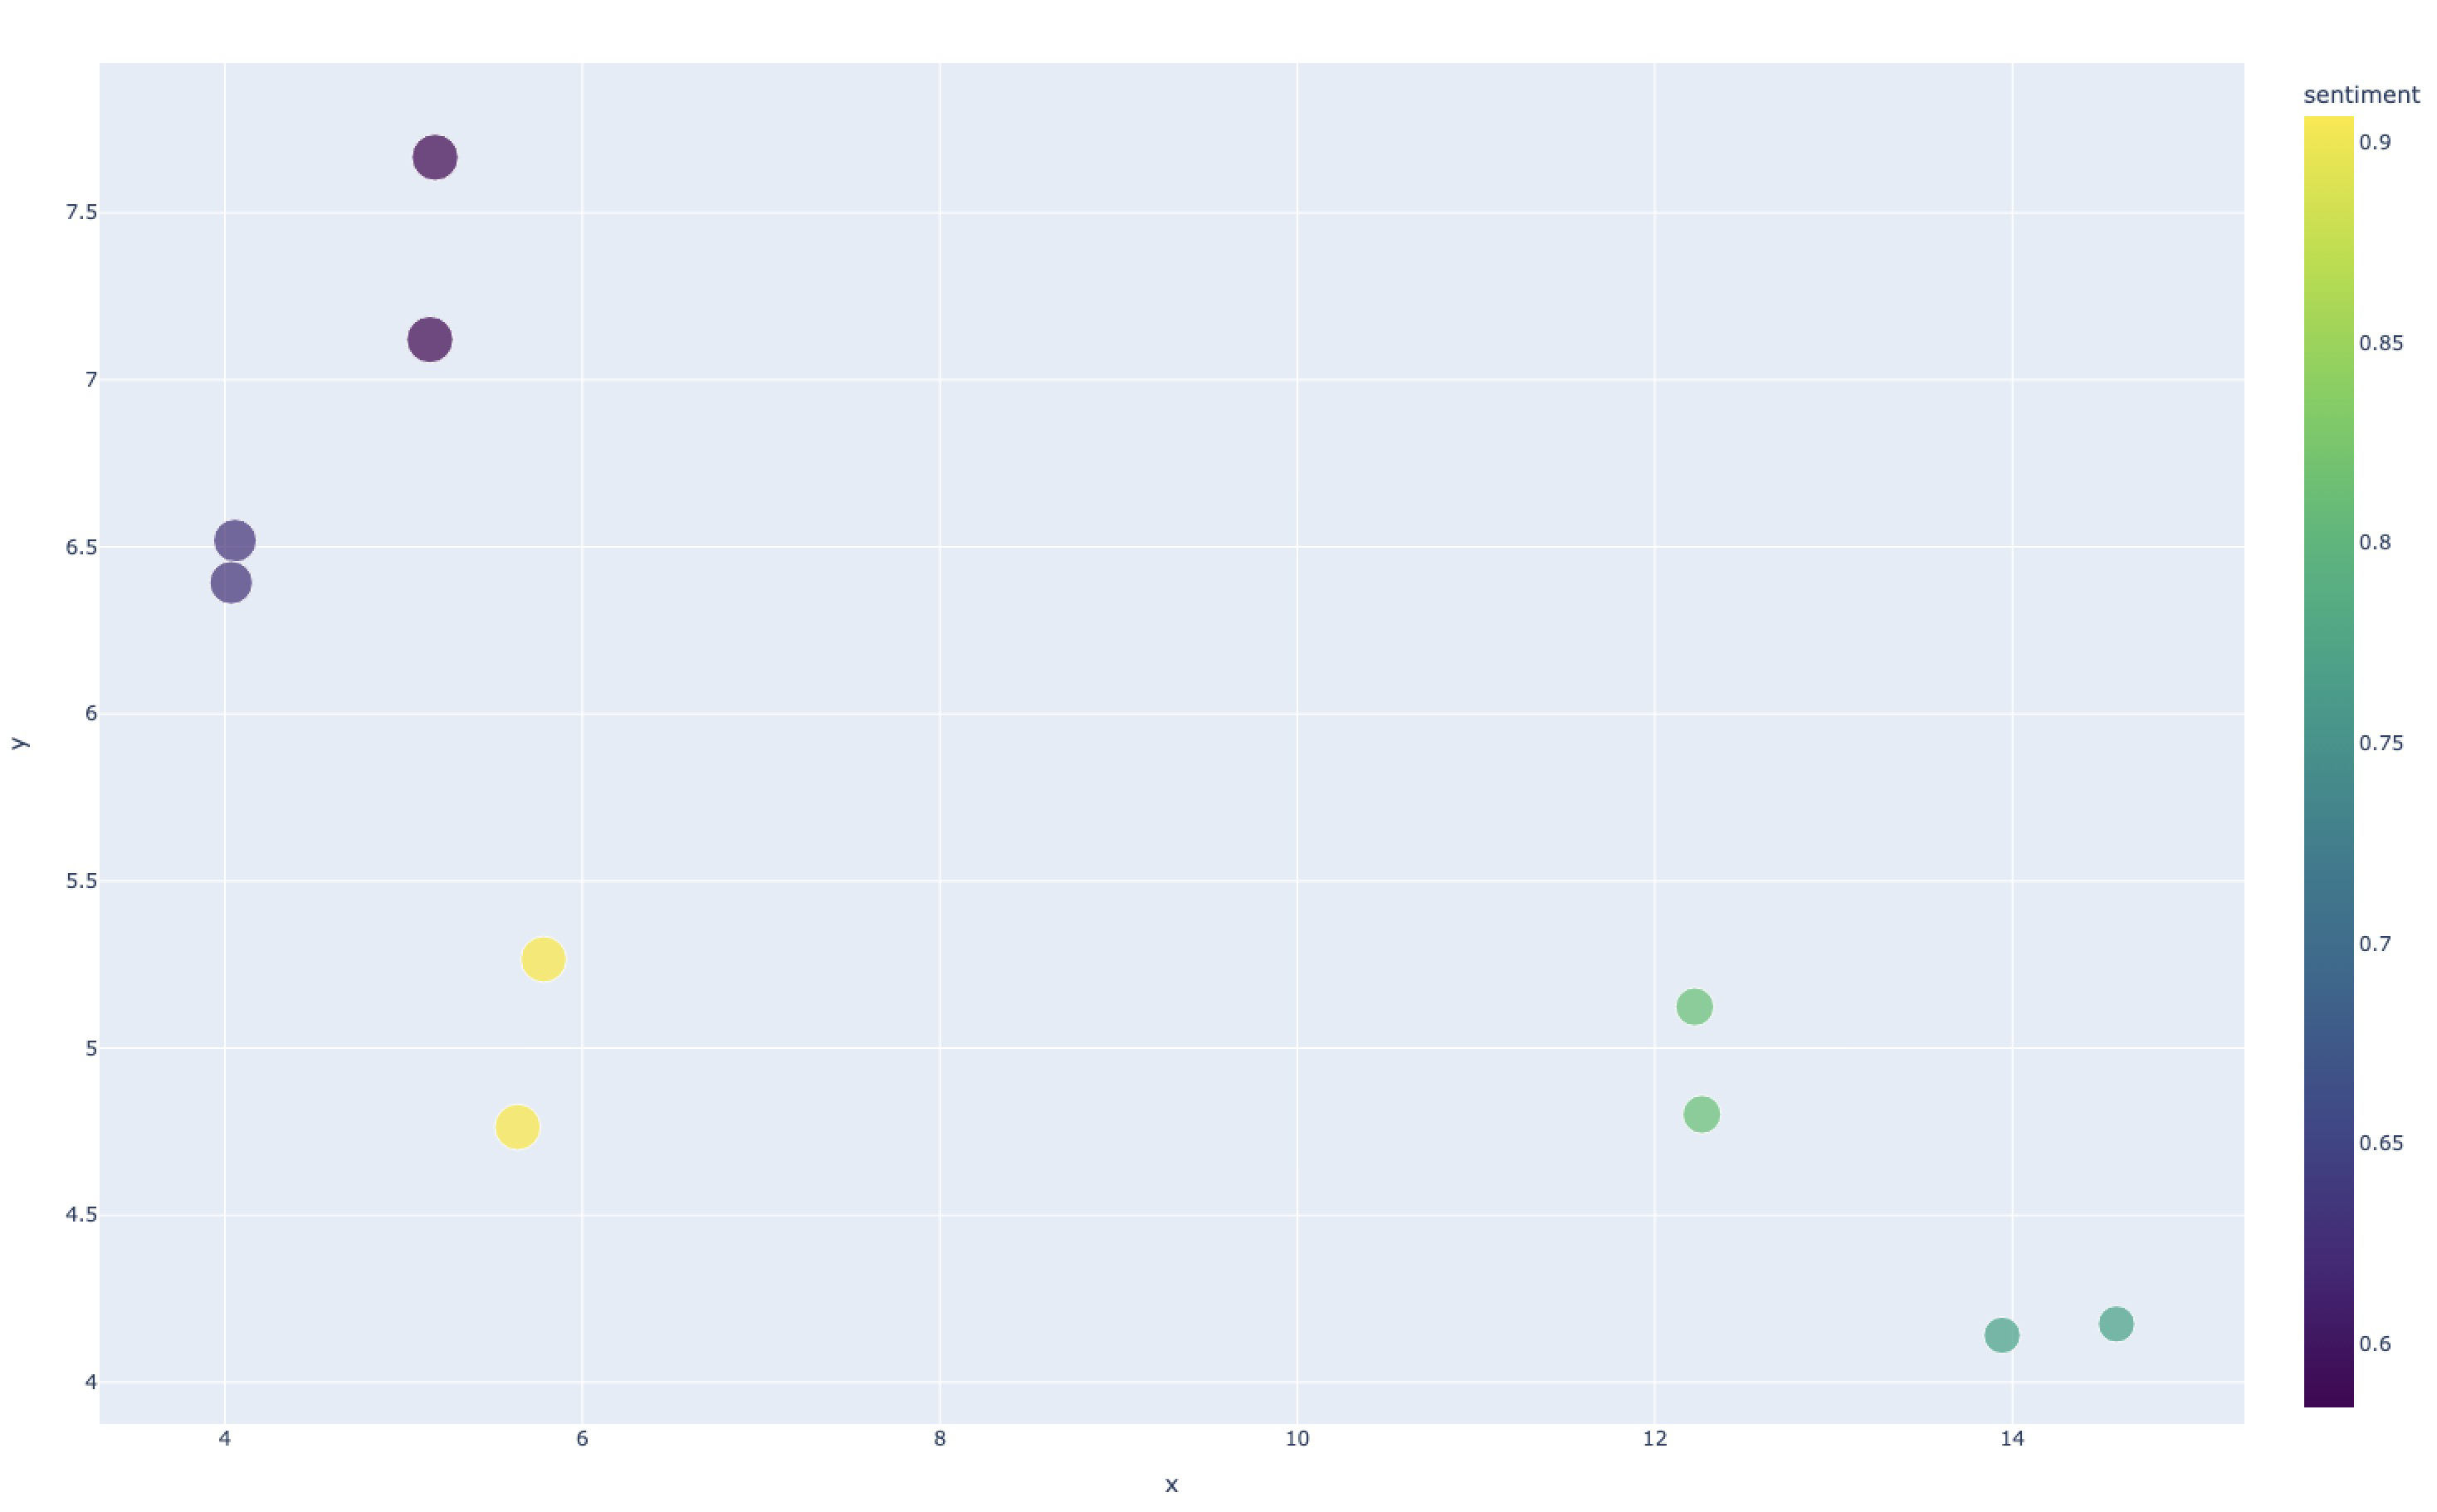

In [10]:
wizard.df["paragraph_sentiment"].value_counts()

paragraph_sentiment
1.0    573
0.0    208
Name: count, dtype: int64

### Summarization

In [11]:
summaries = wizard.df.loc[(~wizard.df["paragraph_sentence_embeddings_clusters_medoids_summaries"].isna()), "paragraph_sentence_embeddings_clusters_medoids_summaries"]
for summary in summaries:
    pprint(summary)
    print()

('Chip-making giant Nvidia (NVDA) could gain another 15% or more this year as '
 'investors continue to back the Artificial Intelligence (AI) revolution. Up '
 'nearly 200% this year, Nvidia soared last month after providing a '
 '‘jaw-dropping’ second-quarter revenue guidance that was 50% higher than Wall '
 'Street expected.')

(' NVIDIA expects significant growth in training and inference for generative '
 'AI workloads. The company aims to reduce the cost per query and enable '
 'widespread adoption across different devices and platforms. NVIDIA focuses '
 'on preprocessing and postprocessing in the inference process and aims to '
 'provide fundamental capabilities.')

('The RTX 4060 is a solid choice of affordable GPU right now. In our review, '
 'we praised its sub-$300 pricing and best-in-class 1080p gaming performance. '
 "If you're already rocking an RTX 3060 or better, this probably isn't a "
 'worthy upgrade.')

('Nvidia is pushing the envelope further in AI hardware with it

### There is always more to explore...